In [16]:
## Import libraries 
import os
import numpy as np
from PIL import Image
import cv2 
import glob
from osgeo import gdal, ogr
import matplotlib.pyplot as plt
import random
import geopandas as gpd
import shapefile as shp 
import rioxarray as rxr
import rasterio as rio
from patchify import patchify
from tkinter import Tcl
import imageio
import csv
import pandas as pd

import tensorflow as tf
tf.__version__

'2.8.0'

In [11]:
""" 
Normalizing within a patch-pair from Kelvin [0,255]
"""
def lst_normalization(lst): 
    lst_min = np.min(lst)
    lst_max = np.max(lst)
    lst_norm = ((lst - lst_min)*(255/(lst_max-lst_min)))
    lst_norm = lst_norm.astype(np.uint8)
    
    return lst_min, lst_max, lst_norm

"""
Denormalizing within a patch-pair from [0,255] to Kelvin 
"""
def lst_denormalization(lst_min, lst_max, lst_norm):
    lst = lst_min + (lst_norm * (lst_max - lst_min))/255
    
    return lst 

"""
Load in RGB and LST imagery from a patch-pair .jpeg file 
"""
def load(image_file):
  # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    # Split each image tensor into two tensors:
    w = tf.shape(image)[1]
    w = w // 2
    lst_img = image[:, w:, :]
    ms_img = image[:, :w, :]

    return lst_img, ms_img

In [8]:
### PATCH-PAIR CREATION ### 
# lst_path = local path to .tif LST files
# rgb_path = local path to .tif RGB files 
# test_path = local path to write testing patch-pairs 
# train_path = local path to write training patch-pairs 

lst_path = '/Volumes/pangan/Training_Data_Full/LST_128/'
rgb_path = '/Volumes/pangan/Training_Data_Full/RGB_128/'
test_path = '/Volumes/pangan/Training_Data_Full/Merged/test_128_norm/'
train_path = '/Volumes/pangan/Training_Data_Full/Merged/train_128_norm/'

lst_list = glob.glob(lst_path + '*.tif')
lst_norm_lookup = {}

# Iterate through all .tif files 
for lst_name in lst_list:
    
    rgb_name = lst_name.replace('LST', 'RGB')
    rgb_file = gdal.Open(rgb_name)
    lst_file = gdal.Open(lst_name)
    
    if rgb_file is not None: 
        rgb_arr = np.array(rgb_file.ReadAsArray())
    else: # Keep track of which LST files are missing corresponding RGB image
        pass
    
    if lst_file is not None: # Keep track of which LST files are missing corresponding RGB image
        lst_arr = np.array(lst_file.ReadAsArray())
    else: 
        pass
    
    # Normalize RGB imagery from 0-255
    r = rgb_arr[0,:,:]
    g = rgb_arr[1,:,:]    
    b = rgb_arr[2,:,:]
    r = ((r-r.min())/r.max())*255
    g = ((g-g.min())/g.max())*255
    b = ((b-b.min())/b.max())*255
    rgb_arr = np.stack((r,g,b))
    rgb_arr = np.ascontiguousarray(rgb_arr.transpose(1,2,0))
    
    # Normalize LST imagery from 0-255
    lst_min, lst_max, lst_arr = lst_normalization(lst_arr)
    lst_arr = lst_arr.T
    lst_arr = np.stack([lst_arr, lst_arr, lst_arr]).T
    lst_arr = lst_arr.astype(int)
    
    # Make sure that only 128x128 patch-pairs are saved 
    if lst_arr.shape[0] != 128 or rgb_arr.shape[0] != 128:
        pass
    else:
        concat = np.concatenate([rgb_arr, lst_arr], 1)
        concat = concat.astype(np.uint8)
                
    out_name = os.path.basename(rgb_name).replace('_RGB_', '_')
    out_name = out_name.replace('tif', 'jpeg')
    lst_norm_lookup[out_name[:len(out_name)-5]] = [lst_min, lst_max]
    
    if random.uniform(0,1) > 0.8: 
        out_name = 'test_' + out_name
        out_path = test_path
    else: 
        out_name = 'train_' + out_name
        out_path = train_path
            
    out_path_full = os.path.join(out_path, out_name)    
    print(out_path_full)
    imageio.imwrite(out_path_full, concat)
        

/Volumes/pangan/Training_Data_Full/Merged/test_128_norm/test_0_chicago_spring_1_1.jpeg


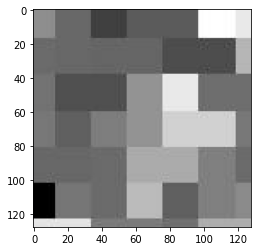

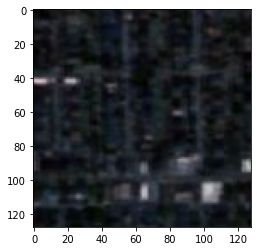

In [14]:
# Test re-importing jpg 

# Test load(image_file) function and plot outputs
lst, ms = load('/Volumes/pangan/Training_Data_Full/Merged/test_128_norm/test_0_chicago_spring_1_1.jpeg')

# Plotting
plt.figure()
plt.imshow(lst)
plt.figure()
plt.imshow(ms)
plt.show()


Original
277.86
275.96
Per-patch norm
277.86
275.96


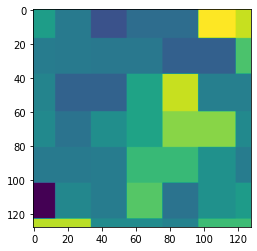

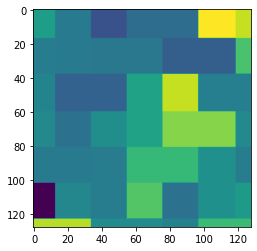

In [9]:
## Confirm that normalization/denormalizatino is producing expected LST temperature ranges 
lst_arr = np.array(lst_file.ReadAsArray())

# By tile min/max
l_min, l_max, norm_2 = lst_normalization(lst_arr)
denorm_2 = lst_denormalization(l_min, l_max, norm_2)

print('Original')
print(np.max(lst_arr))
print(np.min(lst_arr))

print('Per-patch norm')
print(np.max(denorm_2))
print(np.min(denorm_2))

plt.imshow(lst_arr)
plt.show()
plt.imshow(denorm_2)
plt.show()


In [74]:
# Write lookup table to csv
zd_test = zip(*lst_norm_lookup.values())
with open('lst_lookup.csv', 'w') as file:
    writer = csv.writer(file, delimiter=',')
    writer.writerow(lst_norm_lookup.keys())
    writer.writerows(zd_test)

In [21]:
# Open csv file (0 = lst_min, 1 = lst_max)
lst_lookup = pd.read_csv("lst_lookup.csv")
lst_lookup

,0_chicago_spring_1_1,0_chicago_spring_1_2,0_chicago_spring_1_3,0_chicago_spring_1_4,0_chicago_spring_1_5,0_chicago_spring_1_6,0_chicago_spring_2_1,0_chicago_spring_2_2,0_chicago_spring_2_3,0_chicago_spring_2_4,...,8_boulder_fall_3_3,8_boulder_fall_3_4,8_boulder_fall_3_5,8_boulder_fall_3_6,8_boulder_fall_4_1,8_boulder_fall_4_2,8_boulder_fall_4_3,8_boulder_fall_4_4,8_boulder_fall_4_5,8_boulder_fall_4_6
0,275.96,276.34,276.34,275.98,275.84,275.60,275.42,276.88,276.44,275.74,...,288.24,288.50,288.22,288.22,287.72,287.74,288.26,288.34,288.34,288.64
1,277.86,278.10,278.20,278.16,277.42,277.38,278.48,278.48,278.20,277.92,...,289.44,289.88,289.86,289.98,290.64,289.02,289.68,290.14,290.42,289.76
